# Simulate Existing Models

Example created by Wilson Rocha Lacerda Junior

> **Looking for more details on NARMAX models?**
> For comprehensive information on models, methods, and a wide range of examples and benchmarks implemented in SysIdentPy, check out our book:
> [*Nonlinear System Identification and Forecasting: Theory and Practice With SysIdentPy*](https://sysidentpy.org/book/0%20-%20Preface/)
>
> This book provides in-depth guidance to support your work with SysIdentPy.

In [ ]:
pip install sysidentpy

In [1]:
import numpy as np
import pandas as pd
from sysidentpy.simulation import SimulateNARMAX
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.basis_function import Polynomial
from sysidentpy.parameter_estimation import LeastSquares
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)

## Generating 1 input 1 output sample data  
### The data is generated by simulating the following model:

$y_k = 0.2y_{k-1} + 0.1y_{k-1}x_{k-1} + 0.9x_{k-2} + e_{k}$

If *colored_noise* is set to True:

$e_{k} = 0.8\nu_{k-1} + \nu_{k}$

where $x$ is a uniformly distributed random variable and $\nu$ is a gaussian distributed variable with $\mu=0$ and $\sigma=0.1$

In the next example we will generate a data with 1000 samples with white noise and selecting 90% of the data to train the model. 

In [2]:
x_train, x_test, y_train, y_test = get_siso_data(
    n=1000, colored_noise=False, sigma=0.001, train_percentage=90
)

## Defining the model

We already know that the generated data is a result of the model  $𝑦_𝑘=0.2𝑦_{𝑘−1}+0.1𝑦_{𝑘−1}𝑥_{𝑘−1}+0.9𝑥_{𝑘−2}+𝑒_𝑘$ . Thus, we can create a model with those regressors follwing a codification pattern:
- $0$ is the constant term,
- $[1001] = y_{k-1}$
- $[100n] = y_{k-n}$
- $[200n] = x1_{k-n}$
- $[300n] = x2_{k-n}$
- $[1011, 1001] = y_{k-11} \times y_{k-1}$
- $[100n, 100m] = y_{k-n} \times y_{k-m}$
- $[12001, 1003, 1001] = x11_{k-1} \times y_{k-3} \times y_{k-1}$
- and so on

### Important Note

The order of the arrays matter. 

If you use [2001, 1001], it will work, but [1001, 2001] will not (the regressor will be ignored). Always put the highest value first:
- $[2003, 2001]$ **works**
- $[2001, 2003]$ **do not work**

We will handle this limitation in upcoming update.

In [3]:
s = SimulateNARMAX(
    basis_function=Polynomial(), calculate_err=True, estimate_parameter=False
)

# the model must be a numpy array
model = np.array(
    [
        [1001, 0],  # y(k-1)
        [2001, 1001],  # x1(k-1)y(k-1)
        [2002, 0],  # x1(k-2)
    ]
)
# theta must be a numpy array of shape (n, 1) where n is the number of regressors
theta = np.array([[0.2, 0.9, 0.1]]).T

## Simulating the model

After defining the model and theta we just need to use the simulate method.

The simulate method returns the predicted values and the results where we can look at regressors,
parameters and ERR values.

      Regressors  Parameters             ERR
0         y(k-1)  2.0000E-01  0.00000000E+00
1        x1(k-2)  9.0000E-01  0.00000000E+00
2  x1(k-1)y(k-1)  1.0000E-01  0.00000000E+00


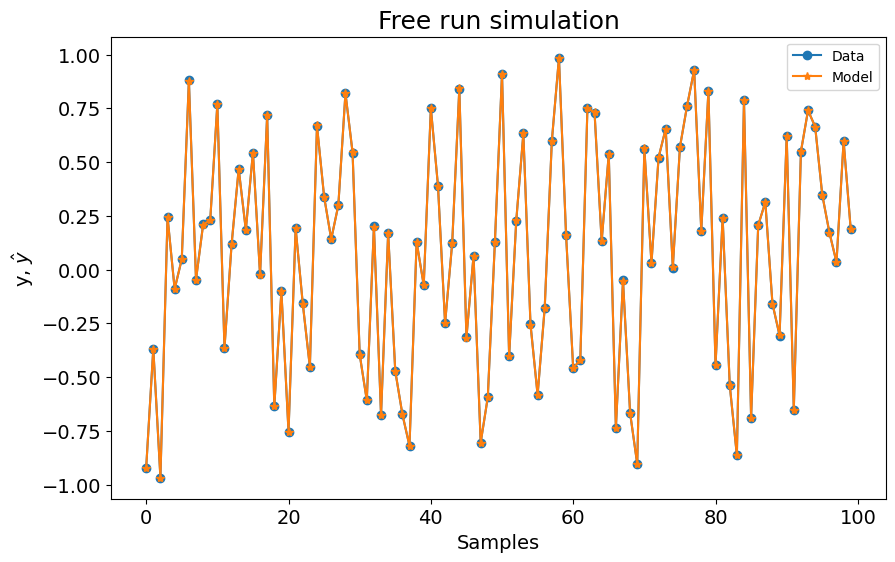

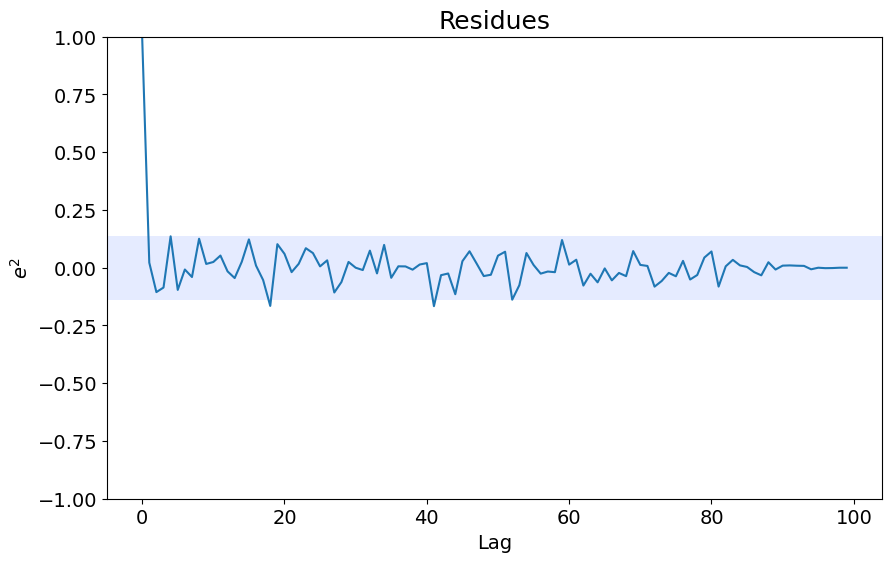

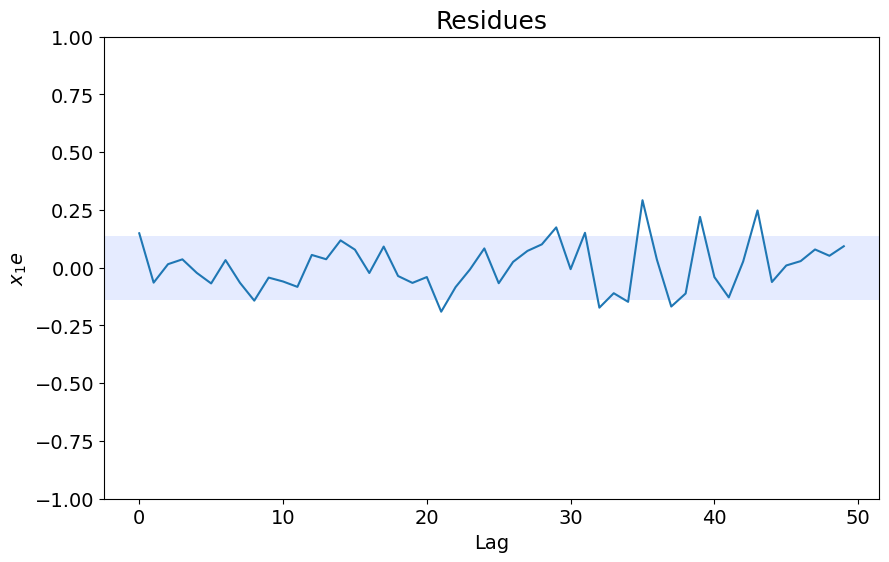

In [4]:
yhat = s.simulate(
    X_test=x_test,
    y_test=y_test,
    model_code=model,
    theta=theta,
)

r = pd.DataFrame(
    results(s.final_model, s.theta, s.err, s.n_terms, err_precision=8, dtype="sci"),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

plot_results(y=y_test, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_test, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_test, yhat, x_test)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

### Options

You can set the `steps_ahead` to run the prediction/simulation:

In [5]:
yhat = s.simulate(
    X_test=x_test,
    y_test=y_test,
    model_code=model,
    theta=theta,
    steps_ahead=1,
)
rrse = root_relative_squared_error(y_test, yhat)
print(rrse)

0.001980394341423956


In [6]:
yhat = s.simulate(
    X_test=x_test,
    y_test=y_test,
    model_code=model,
    theta=theta,
    steps_ahead=21,
)
rrse = root_relative_squared_error(y_test, yhat)
print(rrse)

0.0019394741034286557


### Estimating the parameters

If you have only the model strucuture, you can create an object with `estimate_parameter=True` and
choose the methed for estimation using `estimator`. In this case, you have to pass the training data
for parameters estimation. 

When `estimate_parameter=True`, we also computate the ERR considering only the regressors defined by the user. 

      Regressors  Parameters             ERR
0         y(k-1)  1.9999E-01  9.57682046E-01
1        x1(k-2)  9.0003E-01  3.87716434E-02
2  x1(k-1)y(k-1)  1.0009E-01  3.54306118E-03


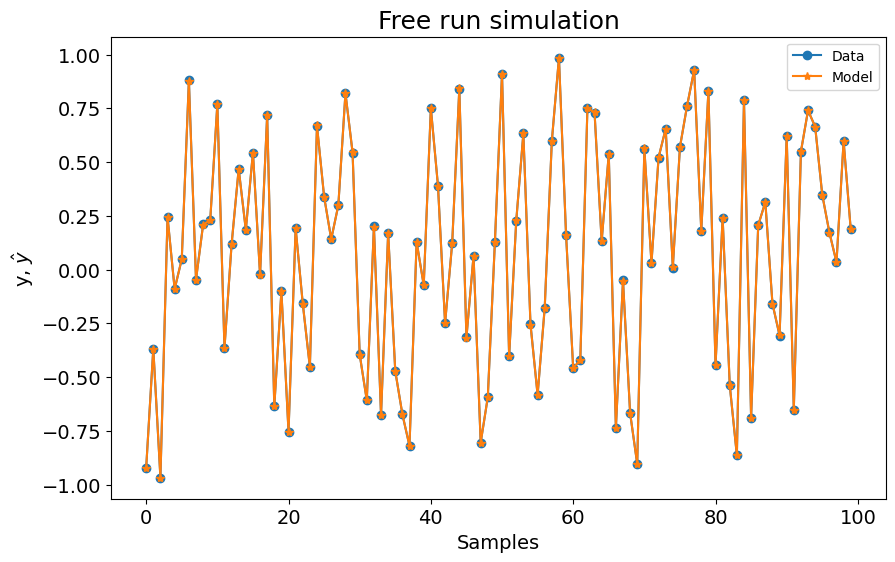

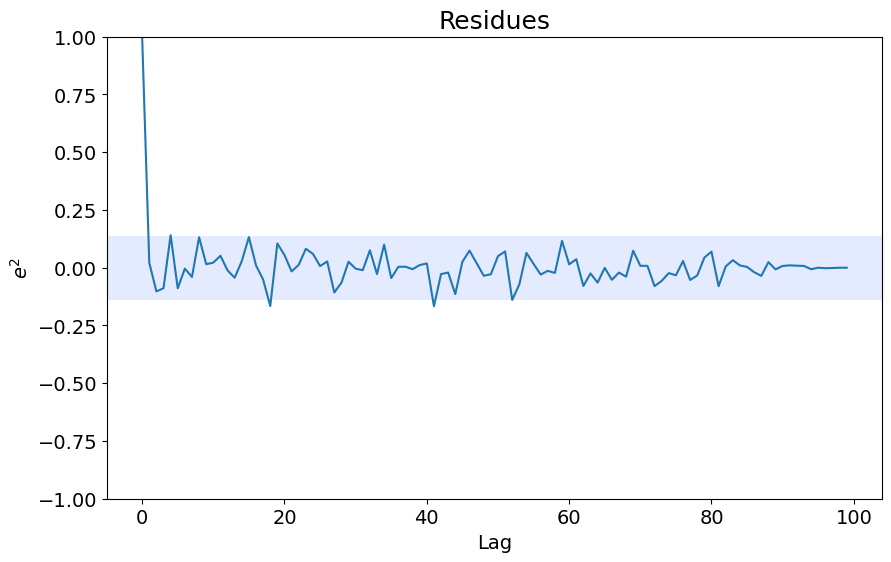

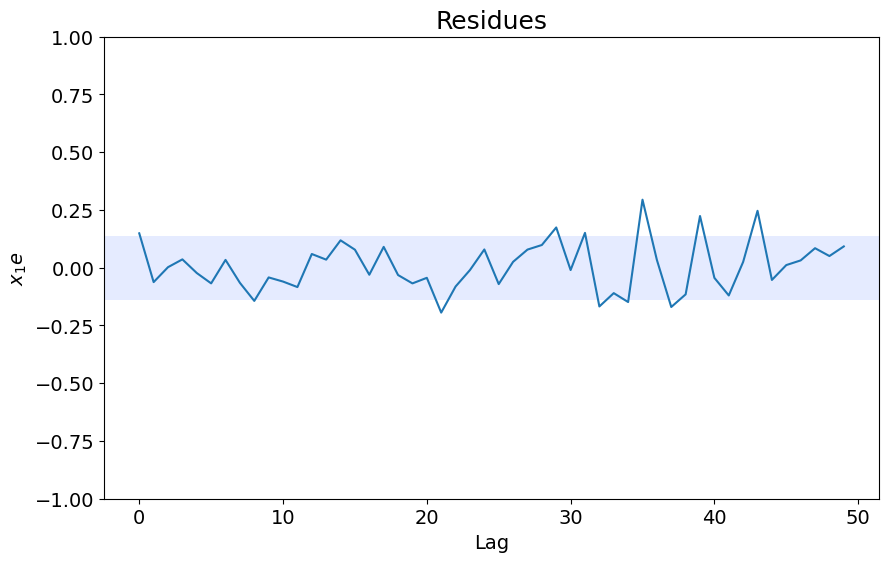

In [7]:
s = SimulateNARMAX(
    basis_function=Polynomial(),
    estimate_parameter=True,
    estimator=LeastSquares(),
    calculate_err=True,
)

yhat = s.simulate(
    X_train=x_train,
    y_train=y_train,
    X_test=x_test,
    y_test=y_test,
    model_code=model,
    # theta will be estimated using the defined estimator
)

r = pd.DataFrame(
    results(s.final_model, s.theta, s.err, s.n_terms, err_precision=8, dtype="sci"),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

plot_results(y=y_test, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_test, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_test, yhat, x_test)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")